# Setting up sparkContext in pyspark

Start a pySpark session including third party packages (SCALA version: 2.11) which will pull from Maven repository:
- __spark-root_2.11:0.1.16__ 
- __histogrammar-sparksql_2.11:1.0.4__

Declares external dependency to the Spark application, in case we are using:

- __XrootD-Connector__

The default cores (defaults at 4) for every spark application is bottlenecked by __SPARK_MASTER_OPTS__ predefined in spark-env.sh. In order to configure spark application beyond the defaults cores, set __spark.cores.max__ in SparkContext before setting:
- __spark.executor.instances__
- __spark.executor.cores__
- __spark.executor.memory__

In the example below, a total of __10 cores__ are allocated to Spark with __5 executors__ (__2 cores per executor__) and __2GB RAM__ per executor.


In [1]:
import pyspark.sql
session = pyspark.sql.SparkSession.builder \
    .master('spark://10.64.22.198:7077') \
    .appName('Zpeak_Nanoaod_keras-SPARK') \
    .config('spark.jars.packages','org.diana-hep:spark-root_2.11:0.1.16,org.diana-hep:histogrammar-sparksql_2.11:1.0.4') \
    .config('spark.driver.extraClassPath','/opt/hadoop/share/hadoop/common/lib/EOSfs.jar') \
    .config('spark.executor.extraClassPath','/opt/hadoop/share/hadoop/common/lib/EOSfs.jar') \
    .config('spark.serializer','org.apache.spark.serializer.KryoSerializer') \
    .config("spark.cores.max", "10") \
    .config('spark.executor.instances', '5') \
    .config('spark.executor.cores','2') \
    .config('spark.executor.memory','2g') \
    .getOrCreate()
    
sqlContext = session
print 'Spark version: ',sqlContext.version
print 'SparkSQL sesssion created'

Spark version:  2.2.1
SparkSQL sesssion created


# Ingesting Nanoaod root file into Dataframe

Dataframe is a RDD (Resilient Distributed Dataset) commonly used as an abstraction in Big Data. A Dataframe is an API to the RDD.

Root files in NANOAOD format serving from remote CERN public EOS area were read via XrootD-Connector and instantiate in Dataframe. A list of root files (dataset and monte carlo background samples) is defined externally in __samples.py__

In [2]:
from pyspark.sql.functions import lit
from samples import *

DFList = [] 

for s in samples:
    print 'Loading {0} sample from EOS file'.format(s) 
    dsPath = "root://eospublic.cern.ch//eos/opstest/cmspd-bigdata/"+samples[s]['filename']    
    tempDF = sqlContext.read \
                .format("org.dianahep.sparkroot") \
                .option("tree", "Events") \
                .load(dsPath) \
                .withColumn("pseudoweight", lit(samples[s]['weight'])) \
                .withColumn("sample", lit(s))                
    DFList.append(tempDF)

Loading TT sample from EOS file
Loading WW sample from EOS file
Loading SingleMuon sample from EOS file
Loading ZZ sample from EOS file
Loading DYJetsToLL sample from EOS file
Loading WZ sample from EOS file


# Access DataFrame content

Return a list of columns in one of the DataFrame, a column corresponds to branche in ROOT TTree.

In [3]:
DFList[0].printSchema()

root
 |-- run: integer (nullable = true)
 |-- luminosityBlock: integer (nullable = true)
 |-- event: long (nullable = true)
 |-- CaloMET_phi: float (nullable = true)
 |-- CaloMET_pt: float (nullable = true)
 |-- CaloMET_sumEt: float (nullable = true)
 |-- nElectron: integer (nullable = true)
 |-- Electron_deltaEtaSC: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dr03EcalRecHitSumEt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dr03HcalDepth1TowerSumEt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dr03TkSumPt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dxy: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dxyErr: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dxyErr_ugo: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_d

# Data reduction

Subsets of interesting attributes can be selected via 'select' operations on the DataFrames (equivalent to "pruning" steps in ROOT-based frameworks).

All datasets can be joined into a single DataFrame (e.g. collecting data from various samples).

In [4]:
# Define interesting attributes to be selected
columns = [
    ### MUON
    'Muon_pt',
    'Muon_eta',
    'Muon_phi',
    'Muon_mass',
    'Muon_charge',
    'Muon_mediumId',
    'Muon_softId',
    'Muon_tightId',
    'nMuon',
    ### SAMPLE
    'sample',
    ### Jet
    'nJet',
    'Jet_pt',
    'Jet_eta',
    'Jet_phi',
    'Jet_mass',
    'Jet_bReg',
    ### Weight
    'pseudoweight',
]

# Select columns from dataframe
DF = DFList[0].select(columns)

# Merge all dataset into a single dataframe
for df_ in DFList[1:]:
    DF = DF.union(df_.select(columns))
    
print 'Partition allocated for Dataframe:',DF.rdd.getNumPartitions(), 'partition'
print 'Partition allocated for Dataframe reported from executors (JVM):',sqlContext._jsc.sc().getExecutorMemoryStatus().size(), 'partition'
print 'Default number of partition (defaultParallelism) = ',sqlContext._jsc.sc().defaultParallelism()

Partition allocated for Dataframe: 6 partition
Partition allocated for Dataframe reported from executors (JVM): 6 partition
Default number of partition (defaultParallelism) =  10


# Events counting

Selection of events based on features is obtained via a 'filter' operation. Number of entries is obtained by 'count'.

NOTE: __Counting number of event is computing expensive task!__

In [5]:
import timeit
start_time = timeit.default_timer()

print 'total number of events in the DataFrame  = ', DF.count()
print 'events in the DataFrame with \"nMuon > 0\" = ', DF.filter('nMuon > 0').count()

elapsed = timeelapsed = timeit.default_timer() - start_time
print 'time elapsed = ',elapsed,' s'

total number of events in the DataFrame  =  2662199
events in the DataFrame with "nMuon > 0" =  1137837
time elapsed =  30.9472751617  s


# Caching - 1

Dataframes can be cached into memory, shared across the Spark cluster nodes, for a faster access. By default the dataset is partitioned according to the number of node.

Caching is an important aspect of Apache Spark, this permits a swift access to 'hot' dataset which is foreseen to alleviate lot of pain in doing optimization on event selection.

The caching will be taken place if an action is invoked on Dataframes

In [6]:
print "Caching will take sometime..."
#DF.cache()
DF.persist() # caching in Memory with serialization
print 'total number of events in the DataFrame  = ', DF.count()

Caching will take sometime...
total number of events in the DataFrame  =  2662199


# Caching - 2

... but ensures __fast data-handling__ operations afterwards.

In [7]:
start_time = timeit.default_timer()
print 'total number of events in the DataFrame  = ', DF.count()
print 'events in the DataFrame with \"nMuon > 0\" = ', DF.filter('nMuon > 0').count()
elapsed = timeelapsed = timeit.default_timer() - start_time
print 'time elapsed = ',elapsed,' s'

total number of events in the DataFrame  =  2662199
events in the DataFrame with "nMuon > 0" =  1137837
time elapsed =  1.75413894653  s


# Data inspection

Events can be inspected with 'show' (as in TTree.Show() ), also concatenating 'select' and 'filter'.

The row correspond to the Event and the column correspond to the variable in the event.

In [8]:
DF.filter(DF['sample'] == 'DYJetsToLL')\
  .select('sample','nMuon','Muon_pt','Muon_eta','Muon_phi','Muon_charge')\
  .show(5)

+----------+-----+-----------+------------+------------+-----------+
|    sample|nMuon|    Muon_pt|    Muon_eta|    Muon_phi|Muon_charge|
+----------+-----+-----------+------------+------------+-----------+
|DYJetsToLL|    1| [34.75507]|[-1.3212891]|[-1.0375977]|        [1]|
|DYJetsToLL|    0|         []|          []|          []|         []|
|DYJetsToLL|    1|[3.3921983]|[-1.5285645]|[-0.2514038]|       [-1]|
|DYJetsToLL|    0|         []|          []|          []|         []|
|DYJetsToLL|    0|         []|          []|          []|         []|
+----------+-----+-----------+------------+------------+-----------+
only showing top 5 rows



# Create derivate quantities and structures - 1

User defined functions can be used for transformations evalueted row by row to compute derived quantity, such as invaraint mass of two physics objects involving multiple column.
The return value is added as a new column in the output DataFrame.

Dimuon candidate structure is created as an example.

In [9]:
from pyspark.sql.types import *

dimuonSchema = StructType([
    StructField("pass", BooleanType(), False),   # True if filled / False if default(empty) 
    #
    StructField("mass", FloatType(), False),     # Dimuon mass
    StructField("pt", FloatType(), False),       # Dimuon pt
    StructField("eta", FloatType(), False),      # Dimuon eta
    StructField("phi", FloatType(), False),      # Dimuon phi
    StructField("dPhi", FloatType(), False),     # DeltaPhi(mu1,mu2)
    StructField("dR", FloatType(), False),       # DeltaR(mu1,mu2)
    StructField("dEta", FloatType(), False),     # DeltaEta(mu1,mu2)
    #
    StructField("pt1", FloatType(), False),   # leading mu pT 
    StructField("pt2", FloatType(), False),   # sub-leading mu pT 
    StructField("eta1", FloatType(), False),  # leading mu eta
    StructField("eta2", FloatType(), False),  # sub-leading mu eta
    StructField("phi1", FloatType(), False),  # leading mu phi
    StructField("phi2", FloatType(), False),  # sub-leading mu phi
])

dijetSchema = StructType([
    StructField("mass", FloatType(), False),     # Dijet mass
    StructField("pt", FloatType(), False),       # Dijet pt
    StructField("eta", FloatType(), False),      # Dijet eta
    StructField("phi", FloatType(), False),      # Dijet phi
    StructField("dPhi", FloatType(), False),     # DeltaPhi(jet1,jet2)
    StructField("dR", FloatType(), False),       # DeltaR(jet1,jet2)
    StructField("dEta", FloatType(), False),     # DeltaEta(jet1,jet2)
])

# Create derivate quantities and structures - 2

And a generic function filling the candidate structure can be defined.

In [10]:
from math import *

def deltaPhi(phi1,phi2):
    ## Catch if being called with two objects
    if type(phi1) != float and type(phi1) != int:
        phi1 = phi1.phi
    if type(phi2) != float and type(phi2) != int:
        phi2 = phi2.phi
    ## Otherwise
    dphi = (phi1-phi2)
    while dphi >  pi: dphi -= 2*pi
    while dphi < -pi: dphi += 2*pi
    return dphi

def deltaR(eta1,phi1,eta2=None,phi2=None):
    ## catch if called with objects
    if eta2 == None:
        return deltaR(eta1.eta,eta1.phi,phi1.eta,phi1.phi)
    ## otherwise
    return hypot(eta1-eta2, deltaPhi(phi1,phi2))

def invMass(pt1, pt2, eta1, eta2, phi1, phi2, mass1, mass2):
    #
    theta1 = 2.0*atan(exp(-eta1))
    px1    = pt1 * cos(phi1)
    py1    = pt1 * sin(phi1)
    pz1    = pt1 / tan(theta1)
    E1     = sqrt(px1**2 + py1**2 + pz1**2 + mass1**2)

    theta2 = 2.0*atan(exp(-eta2))
    px2    = pt2 * cos(phi2)
    py2    = pt2 * sin(phi2)
    pz2    = pt2 / tan(theta2)
    E2     = sqrt(px2**2 + py2**2 + pz2**2 + mass2**2)

    themass  = sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)
    thept    = sqrt((px1 + px2)**2 + (py1 + py2)**2)
    thetheta = atan( thept / (pz1 + pz2) )        
    theeta   = 0.5*log( (sqrt((px1 + px2)**2 + (py1 + py2)**2 + (pz1 + pz2)**2)+(pz1 + pz2))/(sqrt((px1 + px2)**2 + (py1 + py2)**2 + (pz1 + pz2)**2)-(pz1 + pz2)) )
    thephi   = asin((py1 + py2)/thept)

    delPhi = deltaPhi(phi1,phi2)
    delR   = deltaR(eta1,phi1,eta2,phi2)
    delEta = eta1-eta2

    return (themass, thept, theeta, thephi, delPhi, delR, delEta)

def dimuonCandidate(pt, eta, phi, mass, charge, mediumid):
    # default class implementation   
    default_ = (False, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    
    """
    Z->mm candidate from arbitrary muon selection:
      N(mu) >= 2
      pT > 30, 10
      abs(eta) < 2.4, 2.4
      mediumId muon
      opposite charge
    """
    
    if len(pt) < 2:
        return default_
    
    #Identify muon candidate
    leadingIdx = None
    trailingIdx = None
 
    for idx in range(len(pt)):
        if leadingIdx == None:
            if pt[idx] > 30 and abs(eta[idx]) < 2.4 and mediumid[idx]:
                leadingIdx = idx
        elif trailingIdx == None:
            if pt[idx] > 10 and abs(eta[idx]) < 2.4 and mediumid[idx]:
                trailingIdx = idx
        else:
            if pt[idx] > 10 and abs(eta[idx]) < 2.4 and mediumid[idx]:
                return default_

    if leadingIdx != None and trailingIdx != None and charge[leadingIdx] != charge[trailingIdx]:            
        # Candidate found
        dimuon_   = (True,) + \
                    invMass(pt[leadingIdx], pt[trailingIdx],
                            eta[leadingIdx], eta[trailingIdx],
                            phi[leadingIdx], phi[trailingIdx],
                            mass[leadingIdx], mass[trailingIdx]) + \
                    (pt[leadingIdx], pt[trailingIdx],
                     eta[leadingIdx], eta[trailingIdx],
                     phi[leadingIdx], phi[trailingIdx])
                
        return dimuon_
    else:
        return default_

# Create derivate quantities and structures - 3

Finally, a dimuon candidate structure (an array of defined quantities) can be appended to the DataFrame as an additional column

In [11]:
from pyspark.sql.functions import udf
dimuonUDF = udf(dimuonCandidate, dimuonSchema)
DeltaRZJJUDF = udf(deltaR, FloatType())
dijetUDF = udf(invMass, dijetSchema)

DF = DF.withColumn('Dimuon', dimuonUDF ("Muon_pt",
                                        "Muon_eta",
                                        "Muon_phi",
                                        "Muon_mass",
                                        "Muon_charge",
                                        "Muon_mediumId")
                  )

DF = DF.withColumn('Dijet', dijetUDF ( DF["Jet_pt"][0],
                                       DF["Jet_pt"][1],
                                       DF["Jet_eta"][0],
                                       DF["Jet_eta"][1],
                                       DF["Jet_phi"][0],
                                       DF["Jet_phi"][1],
                                       DF["Jet_mass"][0],
                                       DF["Jet_mass"][1]
                                     )
                  )

DF = DF.withColumn('DeltaRZjj', DeltaRZJJUDF( 'Dimuon.eta', 'Dimuon.phi', 'Dijet.eta', 'Dijet.phi' ) )

#DF.persist()

In [12]:
DF.where('Dimuon.pass == True').where('nJet>1').select('pseudoweight','Jet_pt','Dijet.mass','Dijet.pt','Dijet.eta',
                                       'Dijet.phi','Dijet.dPhi','Dijet.dR','Dijet.dEta').show(20)

+------------+--------------------+---------+---------+------------+-----------+----------+---------+-----------+
|pseudoweight|              Jet_pt|     mass|       pt|         eta|        phi|      dPhi|       dR|       dEta|
+------------+--------------------+---------+---------+------------+-----------+----------+---------+-----------+
|         1.0|[144.875, 133.0, ...|266.18433| 82.77507|  -0.8494277|  1.3423173| 2.5425262|2.5425384|0.007873535|
|         1.0|[296.75, 117.9375...|384.89975|186.76892|    2.658716|  0.8562217|  2.852295|2.8922362|  0.4790039|
|         1.0|[103.875, 97.625,...|214.92195|79.381584| -0.59475684| 0.10697864|-2.3339844|2.5484128| -1.0231934|
|         1.0|[146.875, 103.687...|71.931816|246.47768| -0.46654084|  0.9201688|-0.3671875|0.5340018|-0.38772583|
|         1.0|[72.4375, 59.5625...|110.59765| 73.21699| -0.89330715|  1.4185485|-1.9801025|1.9810926|-0.06262207|
|         1.0|[347.0, 152.125, ...|508.27448| 196.0484|  -2.2449017|-0.55854106|-3.04833

# Return statistical information about the data

Exploit pySparkSql functions to get statistical insights on the DataFrame

In [13]:
from pyspark.sql.functions import *

print 'Number of events, pre-selection level'

DF.groupBy("sample").count().show()

print 'Number of events, Dimuon invariant mass in [70-110] GeV'

DF.where( (col("Dimuon.mass") > 70) & (col("Dimuon.mass") < 110) ).groupBy("sample").count().show()

print 'Mean of Dimuon mass, evaluated in [70-110] GeV range'

DF.where( (col("Dimuon.mass") > 70) & (col("Dimuon.mass") < 110) ).groupBy('sample').mean('Dimuon.mass').show()

print 'Description of Dimuon mass features for SingleMuon dataset only, evaluated in [70-110] GeV range'

DF.where( (col("Dimuon.mass") > 70) & (col("Dimuon.mass") < 110) & (DF["sample"] == "SingleMuon") ).describe('Dimuon.mass').show()
#DF = DF.filter('Muon_pt[0] > 40').filter('Muon_pt[1] > 40')

Number of events, pre-selection level
+----------+------+
|    sample| count|
+----------+------+
|        ZZ|480144|
|        WW|348954|
|DYJetsToLL|549790|
|SingleMuon|477186|
|        WZ|424048|
|        TT|382077|
+----------+------+

Number of events, Dimuon invariant mass in [70-110] GeV
+----------+-----+
|    sample|count|
+----------+-----+
|        ZZ|16201|
|        WW|  710|
|DYJetsToLL|67831|
|SingleMuon|13934|
|        WZ| 7209|
|        TT| 1760|
+----------+-----+

Mean of Dimuon mass, evaluated in [70-110] GeV range
+----------+--------------------------+
|    sample|avg(Dimuon.mass AS `mass`)|
+----------+--------------------------+
|        ZZ|         90.39599790585481|
|        WW|         88.08453911794743|
|DYJetsToLL|         90.19341036229169|
|SingleMuon|         89.91447557800039|
|        WZ|         90.19251177561962|
|        TT|         86.54928711977873|
+----------+--------------------------+

Description of Dimuon mass features for SingleMuon dataset o

# Plotting the interesting variables of dijet and dimuon

Interesting variables are plotted using accumulator from Histogrammar package and the graphic object is handled by backend matplotlib.

In [14]:
# Load libraries, and append histogrammar functionalities to dataframe
import matplotlib.pyplot as plt
%matplotlib inline
import histogrammar as hg
import histogrammar.sparksql
import numpy as np

DF = DF.where( (col("Dimuon.mass") > 70) & (col("Dimuon.mass") < 110) & (col("nJet")>1) )

hg.sparksql.addMethods(DF)

plots = hg.UntypedLabel(
    LeadMuPt       = hg.Bin(20, 0, 500,    DF['Dimuon.pt1'], hg.Sum(DF['pseudoweight'])),
    LeadMuEta      = hg.Bin(48, -2.4, 2.4, DF['Dimuon.eta1'], hg.Sum(DF['pseudoweight'])),
    SubLeadMuPt    = hg.Bin(20, 0, 500,    DF['Dimuon.pt2'], hg.Sum(DF['pseudoweight'])),
    SubLeadMuEta   = hg.Bin(48, -2.4, 2.4, DF['Dimuon.eta2'], hg.Sum(DF['pseudoweight'])),
    ZInvMass      = hg.Bin(80, 70, 110,   DF['Dimuon.mass'], hg.Sum(DF['pseudoweight'])),
    ZDeltaR       = hg.Bin(20, 0, 3,      DF['Dimuon.dPhi'], hg.Sum(DF['pseudoweight'])),
    ZDeltaPhi     = hg.Bin(10, 0, 3,      DF['Dimuon.dR'], hg.Sum(DF['pseudoweight'])),
    
    LeadJetPt       = hg.Bin(20, 0, 500,    DF['Jet_pt'][0], hg.Sum(DF['pseudoweight'])),
    LeadJetEta      = hg.Bin(48, -2.4, 2.4, DF['Jet_eta'][0], hg.Sum(DF['pseudoweight'])),
    SubLeadJetPt    = hg.Bin(20, 0, 500,    DF['Jet_pt'][1], hg.Sum(DF['pseudoweight'])),
    SubLeadJetEta   = hg.Bin(48, -2.4, 2.4, DF['Jet_eta'][1], hg.Sum(DF['pseudoweight'])),
    JJInvMass      = hg.Bin(80, 70, 110,   DF['Dijet.mass'], hg.Sum(DF['pseudoweight'])),
    JJDeltaR       = hg.Bin(20, 0, 3,      DF['Dijet.dPhi'], hg.Sum(DF['pseudoweight'])),
    JJDeltaPhi     = hg.Bin(10, 0, 3,      DF['Dijet.dR'], hg.Sum(DF['pseudoweight'])),
    ZJJDeltaR       = hg.Bin(20, 0, 3,      DF['DeltaRZjj'], hg.Sum(DF['pseudoweight'])),
)

# Make a set of histograms, categorized per-sample
bulkHisto = hg.Categorize(quantity = DF['sample'], value = plots)

# Fill from spark
bulkHisto.fillsparksql(df=DF)
print 'Filling histogrammar done'

Filling histogrammar done


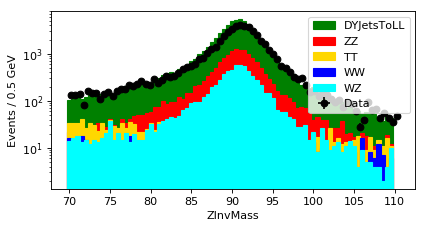

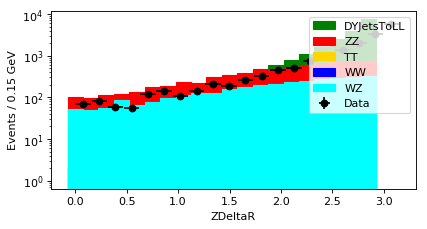

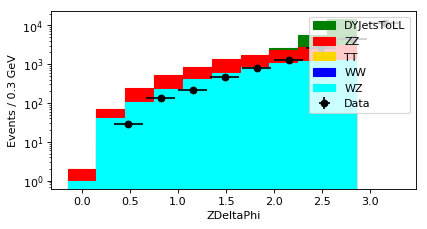

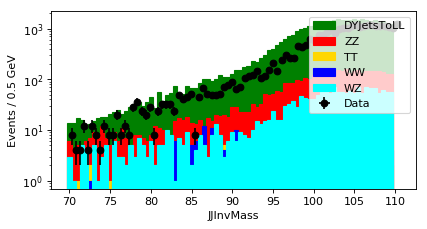

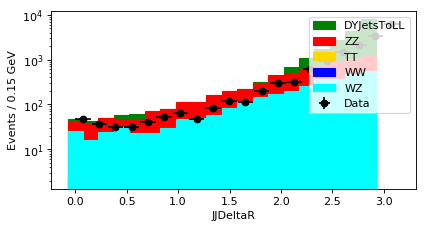

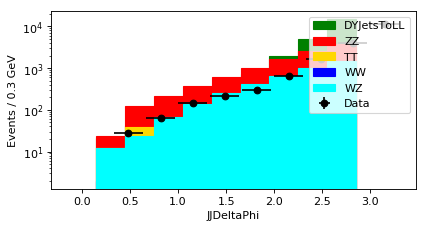

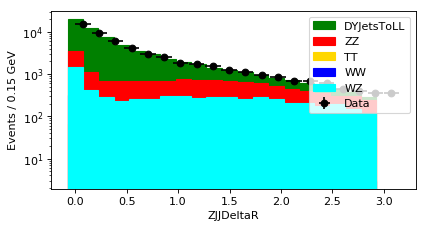

In [15]:
for VARIABLE, num in zip(['ZInvMass','ZDeltaR','ZDeltaPhi','JJInvMass','JJDeltaR','JJDeltaPhi','ZJJDeltaR'],
                         ['331','332','333','334','335','336','337']
                        ):
    
    fig = plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

    #aHisto   = bulkHisto("SingleMuon")(VARIABLE)
    #nBins    = len(aHisto.values)
    #edges    = np.linspace(aHisto.low, aHisto.high, nBins + 1)
    #width    = (aHisto.high - aHisto.low) / nBins

    plotVals = {}
    plt.subplot(num)
    
    #for k in bulkHisto.bins:
    for k in ['DYJetsToLL','ZZ','TT','WW','WZ']:
        aHisto   = bulkHisto(k)(VARIABLE)
        nBins    = len(aHisto.values)
        edges    = np.linspace(aHisto.low, aHisto.high, nBins + 1)
        width    = (aHisto.high - aHisto.low) / nBins
            
        #plotVals[k] = [x.toJson()['data']*0.19 for x in bulkHisto(k)(VARIABLE).values]
        plotVals[k] = [x.sum for x in bulkHisto(k)(VARIABLE).values]
        plt.bar(edges[:-1], plotVals[k], width=width, label=k, color=samples[k]['color'], edgecolor=samples[k]['color'], fill=True)
    
    xdata   = np.linspace(aHisto.low+0.5*width, aHisto.high+0.5*width, nBins)    
    #ydata   = [x.toJson()['data'] for x in bulkHisto('SingleMuon')(VARIABLE).values]
    ydata   = [x.sum*4 for x in bulkHisto('SingleMuon')(VARIABLE).values]
    yerror  = [x**0.5 for x in ydata]

    plt.errorbar(xdata, ydata, fmt='ko', label="Data", xerr=width/2, yerr=yerror, ecolor='black')
    
    #if VARIABLE[-2:] == "Pt":
    #    plt.xlabel('Pt of Muon (GeV/c)')
    #elif VARIABLE[-4:] == "Mass":
    #    plt.xlabel('Dimuon invariant mass m($\mu\mu$) (GeV)')
    #else:
    #    plt.xlabel('Angular Unit')
    plt.xlabel('%s' %VARIABLE)
        
    plt.ylabel('Events / %s GeV' %width)
    plt.yscale('log')
    plt.legend(loc='upper right', fontsize='x-large', prop={'size': 10})

# ML Learning Extension

Preparing dataframe for machin learning. Here we define the set of features distinguishing the signal VH and backgrounds.

In [16]:
from pyspark.sql.functions import udf
from pyspark.sql.functions import rand
from pyspark.ml.linalg import Vectors, VectorUDT
#from pyspark.mllib.linalg import Vectors, VectorUDT
vectorizer = udf(lambda x: Vectors.dense(x), VectorUDT())

##Construct Desire Features:
#nFeatures = vectorizer(
#    array(
#        DF['Muon_Pt'][0],
#        DF['Muon_Eta'][0], 
#        DF['Jet_Pt'][0], 
#        DF['Jet_Eta'][0]
#    )
#) # 4 variables
nFeatures = vectorizer(
    array(
        'Dimuon.mass','Dimuon.dPhi','Dimuon.dR','Dijet.mass','Dijet.dPhi','Dijet.dR','DeltaRZjj'
    )
)


pseudodata = DF.withColumn( "features" , nFeatures ).select("features","sample")

#Split 
pseudodata = pseudodata.where( (col('sample') == "DYJetsToLL") | (col('sample') == "ZH") )
#Rename sample to Label
dataset = pseudodata.selectExpr("features as features", "sample as label").orderBy(rand())

In [17]:
dataset.show(30)

+--------------------+----------+
|            features|     label|
+--------------------+----------+
|[85.6306076049804...|DYJetsToLL|
|[91.6400756835937...|DYJetsToLL|
|[95.537353515625,...|DYJetsToLL|
|[95.5703506469726...|DYJetsToLL|
|[93.5673446655273...|DYJetsToLL|
|[89.2838821411132...|DYJetsToLL|
|[97.0940551757812...|DYJetsToLL|
|[88.3369369506836...|DYJetsToLL|
|[88.8952484130859...|DYJetsToLL|
|[94.0004425048828...|DYJetsToLL|
|[87.6924438476562...|DYJetsToLL|
|[93.3152389526367...|DYJetsToLL|
|[84.1065139770507...|DYJetsToLL|
|[86.8233413696289...|DYJetsToLL|
|[86.8294219970703...|DYJetsToLL|
|[90.4663467407226...|DYJetsToLL|
|[88.4087753295898...|DYJetsToLL|
|[91.5196685791015...|DYJetsToLL|
|[92.7576370239257...|DYJetsToLL|
|[92.3906402587890...|DYJetsToLL|
|[92.2282791137695...|DYJetsToLL|
|[93.7047271728515...|DYJetsToLL|
|[88.3339996337890...|DYJetsToLL|
|[91.3839721679687...|DYJetsToLL|
|[88.1730575561523...|DYJetsToLL|
|[91.3683395385742...|DYJetsToLL|
|[96.088424682

## Preprocessing dataframe

StringIndexer --> encodes a string column of labels to a column of label indices. The indices are in [0, numLabels), ordered by label frequencies, so the most frequent label gets index 0

StandardScaler --> Apply feature normalization with standard scaling using Spark's StandardScaler. This will transform a feature to have mean 0, and std 1.

In [18]:
from pyspark.ml.feature import StringIndexer

string_indexer = StringIndexer(inputCol="label", outputCol="index_label")
fitted_indexer = string_indexer.fit(dataset)
indexed_df = fitted_indexer.transform(dataset)

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
fitted_scaler = scaler.fit(indexed_df)
scaled_df = fitted_scaler.transform(indexed_df)
print("The result of indexing and scaling. Each transformation adds new columns to the data frame:")
scaled_df.show(10)

The result of indexing and scaling. Each transformation adds new columns to the data frame:
+--------------------+----------+-----------+--------------------+
|            features|     label|index_label|     scaled_features|
+--------------------+----------+-----------+--------------------+
|[85.6306076049804...|DYJetsToLL|        0.0|[-0.9134071599378...|
|[91.6400756835937...|DYJetsToLL|        0.0|[0.28949016829994...|
|[95.537353515625,...|DYJetsToLL|        0.0|[1.06959666528505...|
|[95.5703506469726...|DYJetsToLL|        0.0|[1.07620160279672...|
|[93.5673446655273...|DYJetsToLL|        0.0|[0.67526586073002...|
|[89.2838821411132...|DYJetsToLL|        0.0|[-0.1821420760159...|
|[97.0940551757812...|DYJetsToLL|        0.0|[1.38119700051761...|
|[88.3369369506836...|DYJetsToLL|        0.0|[-0.3716892746455...|
|[88.8952484130859...|DYJetsToLL|        0.0|[-0.2599337319481...|
|[94.0004425048828...|DYJetsToLL|        0.0|[0.76195776540630...|
+--------------------+----------+----

After reading the dataset from storage, we will extract several metrics such as nb_features, which basically is the number of input neurons, and nb_classes, which is the number of classes (signal and background).

In [19]:
nb_features = len(scaled_df.select("features").take(1)[0]["features"])
nb_classes = len(scaled_df.select("label").take(1)[0]["label"])
#nb_classes = 1

print("Number of features: " + str(nb_features))
print("Number of classes: " + str(nb_classes))

Number of features: 7
Number of classes: 10


## Caching training set and test set in memory (WARNING)

split up the dataset for training and testing purposes, and fetch some additional statistics on the number of training and testing instances.

In [20]:
(training_set, test_set) = scaled_df.randomSplit([0.7, 0.3])

## Distributing the training and test set to the workers

caching the test set and training set to each executor in order to perform training in parallelism.

In [21]:
test_set = test_set.repartition(5)
training_set = training_set.repartition(5)

##release DF
#DF.unpersist()

training_set.cache()
test_set.cache()

num_test_set = test_set.count()
num_training_set = training_set.count()

print("Number of testset instances: " + str(num_test_set))
print("Number of trainingset instances: " + str(num_training_set))
print("Total number of instances: " + str(num_test_set + num_training_set))

test_set.show()

Number of testset instances: 20452
Number of trainingset instances: 47384
Total number of instances: 67836
+--------------------+----------+-----------+--------------------+
|            features|     label|index_label|     scaled_features|
+--------------------+----------+-----------+--------------------+
|[79.6181945800781...|DYJetsToLL|        0.0|[-2.1168939693038...|
|[84.9314117431640...|DYJetsToLL|        0.0|[-1.0533631132920...|
|[87.4548797607421...|DYJetsToLL|        0.0|[-0.5482480354632...|
|[88.2836303710937...|DYJetsToLL|        0.0|[-0.3823594939274...|
|[88.4087753295898...|DYJetsToLL|        0.0|[-0.3573096002849...|
|[88.961669921875,...|DYJetsToLL|        0.0|[-0.2466383363466...|
|[89.5400695800781...|DYJetsToLL|        0.0|[-0.1308617993212...|
|[90.2108383178711...|DYJetsToLL|        0.0|[0.00340398127719...|
|[90.5589599609375...|DYJetsToLL|        0.0|[0.07308645381359...|
|[90.9385986328125...|DYJetsToLL|        0.0|[0.14907759614437...|
|[91.0063171386718...|

## Keras Model Construction

A 4 layers of neural network each consist of 100 neuron are constructed for the training.

In [22]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
model = Sequential()
model.add(Dense(100, input_shape=(nb_features,)))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.6))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.summary()

/usr/lib64/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               800       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
__________

In [23]:
optimizer = 'adagrad'
loss = 'categorical_crossentropy'

## Model Evaluation

Define model evaluation function

In [24]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from distkeras.transformers import LabelIndexTransformer
from distkeras.predictors import ModelPredictor
from distkeras.evaluators import *

from distkeras.trainers import SingleTrainer
#from distkeras.trainers import AEASGD
#from distkeras.trainers import DOWNPOUR

def evaluate(model):
    global test_set

    metric_name = "f1"
    evaluator = MulticlassClassificationEvaluator(metricName=metric_name, predictionCol="prediction_index", labelCol="index_label")
    # Clear the prediction column from the testset.
    test_set1 = test_set.select("scaled_features", "label", "index_label")
    # Apply a prediction from a trained model.
    predictor = ModelPredictor(keras_model=trained_model, features_col="scaled_features")
    test_set1 = predictor.predict(test_set1)
    # Transform the prediction vector to an indexed label.
    index_transformer = LabelIndexTransformer(output_dim=nb_classes)
    test_set1 = index_transformer.transform(test_set1)
    # Store the F1 score of the SingleTrainer.
    score = evaluator.evaluate(test_set1)
    
    return score

def evaluate_accuracy(model, test_set, features="scaled_features"):
    evaluator = AccuracyEvaluator(prediction_col="prediction_index", label_col="index_label")
    predictor = ModelPredictor(keras_model=trained_model, features_col=features)
    transformer = LabelIndexTransformer(output_dim=nb_classes)
    test_set2 = test_set.select(features, "index_label")
    test_set2 = predictor.predict(test_set2)
    test_set2 = transformer.transform(test_set2)
    score = evaluator.evaluate(test_set2)
    
    return score

results = {}
time_spent = {}

## Model Training and evaluation: SingleTrainer

In [25]:
trainer = SingleTrainer(keras_model=model, loss=loss, worker_optimizer=optimizer, 
                        features_col="scaled_features", num_epoch=1, batch_size=64)
trained_model = trainer.train(training_set)

In [26]:
# Fetch the training time.
dt = trainer.get_training_time()
print("Time spent (SingleTrainer): " + `dt` + " seconds.")

# Evaluate the model.
score = evaluate(trained_model)
print("F1 (SingleTrainer): " + `score`)

# Evaluate Accuracy
accuracy = evaluate_accuracy(trained_model,test_set)
print("Accuracy: " + `accuracy`)

# Store the training metrics.
results['single'] = score
time_spent['single'] = dt

Time spent (SingleTrainer): 10.819283962249756 seconds.
F1 (SingleTrainer): 0.3487142222760486
Accuracy: 0.21117739096420887


In [27]:
test_set.show()

+--------------------+----------+-----------+--------------------+
|            features|     label|index_label|     scaled_features|
+--------------------+----------+-----------+--------------------+
|[79.6181945800781...|DYJetsToLL|        0.0|[-2.1168939693038...|
|[84.9314117431640...|DYJetsToLL|        0.0|[-1.0533631132920...|
|[87.4548797607421...|DYJetsToLL|        0.0|[-0.5482480354632...|
|[88.2836303710937...|DYJetsToLL|        0.0|[-0.3823594939274...|
|[88.4087753295898...|DYJetsToLL|        0.0|[-0.3573096002849...|
|[88.961669921875,...|DYJetsToLL|        0.0|[-0.2466383363466...|
|[89.5400695800781...|DYJetsToLL|        0.0|[-0.1308617993212...|
|[90.2108383178711...|DYJetsToLL|        0.0|[0.00340398127719...|
|[90.5589599609375...|DYJetsToLL|        0.0|[0.07308645381359...|
|[90.9385986328125...|DYJetsToLL|        0.0|[0.14907759614437...|
|[91.0063171386718...|DYJetsToLL|        0.0|[0.16263260778681...|
|[91.3381423950195...|DYJetsToLL|        0.0|[0.22905308112670